**Bangkit Final Project: Medicare - Medical Records powered by AI**



### **Importing Modules** <a id="4"></a>


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv1D, MaxPool1D, Flatten, Dense,Dropout, BatchNormalization, LeakyReLU
from sklearn.model_selection import train_test_split
print(tf.__version__)

2.5.0


In [2]:
#Import the visualization libraries
import seaborn as sn
import matplotlib.pyplot as plt

In [3]:
#import access
import os

In [4]:
#Report
import tensorboard
import time

### **Kaggle Connect** <a id="4"></a>


In [ ]:
from google.colab import files
files.upload() #Kaggle.json 

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"naufalalhakim","key":"e19ce9036d9ed26577d9e42c300f6eb1"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d mathchi/diabetes-data-set

  0% 0.00/8.91k [00:00<?, ?B/s]
100% 8.91k/8.91k [00:00<00:00, 8.32MB/s]


In [ ]:
import zipfile
local_zip = '/content/diabetes-data-set.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

### **Reading CSV from Kaggle** <a id="4"></a>


In [ ]:
df = pd.read_csv('/content/diabetes.csv', sep=",")
#Lets get the first 5 entries of the dataset
df.head()

In [ ]:
df.shape
#The dataset contains 768 entries with t 9 variables,  8 of the variables are independent features while 1 i the target variable(Outcome)

In [ ]:
df.columns

Dropp

In [ ]:
df_dropped = df.drop(['DiabetesPedigreeFunction'], axis = 1)

In [ ]:
df_dropped

### **Gdrive Connect** <a id="4"></a>


Kalo mau datanya https://www.kaggle.com/mathchi/diabetes-data-set/download


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Reading CSV from Drive** <a id="4"></a>


In [6]:
df = pd.read_csv('/content/drive/MyDrive/Final Project bangkit/diabetes.csv', sep=",")
#Lets get the first 5 entries of the dataset
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [7]:
df.shape
#The dataset contains 768 entries with t 9 variables,  8 of the variables are independent features while 1 i the target variable(Outcome)

(768, 9)

In [8]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

Dropp

In [9]:
df_dropped = df.drop(['DiabetesPedigreeFunction'], axis = 1)

In [10]:
df_dropped

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Age,Outcome
0,6,148,72,35,0,33.6,50,1
1,1,85,66,29,0,26.6,31,0
2,8,183,64,0,0,23.3,32,1
3,1,89,66,23,94,28.1,21,0
4,0,137,40,35,168,43.1,33,1
...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,63,0
764,2,122,70,27,0,36.8,27,0
765,5,121,72,23,112,26.2,30,0
766,1,126,60,0,0,30.1,47,1


### **Checking Duplication and Missing Values** <a id="4"></a>

    
Before visualization and outlier checks it is very important to handle duplicate and missing values.

In [11]:
print("There is {} duplicated values in data frame".format(df_dropped.duplicated().sum()))

There is 0 duplicated values in data frame


* We can drop the duplicates because they have no any effect of training of model.
* Firstly let us see the duplicated rows with eyes.

### **Split Data into Train, val, and test** <a id="4"></a>
The dataset we downloaded was a single CSV file. We will split this into train, validation, and test sets.

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
x = df_dropped.drop('Outcome',axis=1)
y = df_dropped['Outcome']
le = LabelEncoder()
y = le.fit_transform(y)

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2, shuffle = True, stratify=y)
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=0.02, shuffle = True,)
print(len(x_train), 'train examples')
print(len(x_test), 'test examples')
print(len(x_val), 'val examples')
print(len(y_train), 'train examples')
print(len(y_test), 'test examples')
print(len(y_val), 'train examples')

601 train examples
154 test examples
13 val examples
601 train examples
154 test examples
13 train examples


In [13]:
x_train.shape,x_test.shape,x_val.shape,y_train.shape,y_test.shape,y_val.shape

((601, 7), (154, 7), (13, 7), (601,), (154,), (13,))

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

In [16]:
x_train = x_train.reshape(601,7,1)
x_test = x_test.reshape(154,7,1)
x_val = x_val.reshape(13,7,1)

In [17]:
x_train.shape,x_test.shape,x_val.shape

((601, 7, 1), (154, 7, 1), (13, 7, 1))

### **Create, compile, and train the model** <a id="4"></a>

In [25]:
model = tf.keras.Sequential([
                             tf.keras.layers.Conv1D(filters=64,kernel_size=1,activation='LeakyReLU',input_shape=(7,1)),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dropout(0.2),

                             tf.keras.layers.Conv1D(filters=64, kernel_size=1, activation = 'LeakyReLU'),
                             tf.keras.layers.BatchNormalization(),

                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(128, activation = 'LeakyReLU'),
                             tf.keras.layers.Dropout(0.2),
                             
                             tf.keras.layers.Dense(1, activation = 'sigmoid')])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 7, 64)             128       
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 64)             256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 64)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 7, 64)             4160      
_________________________________________________________________
batch_normalization_3 (Batch (None, 7, 64)             256       
_________________________________________________________________
flatten_1 (Flatten)          (None, 448)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

In [26]:
model.compile(optimizer=Adam(learning_rate=0.00005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [20]:
import datetime, os
%load_ext tensorboard

In [27]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.84):
      print("\nReached 84% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()
history = model.fit(x_train,y_train,
                    validation_data=(x_test,y_test),
                    verbose=1,
                    epochs=1500, callbacks=[tensorboard_callback,callbacks])

Epoch 1/1500
19/19 [==============================] - 2s 24ms/step - loss: 0.8491 - accuracy: 0.5008 - val_loss: 0.6831 - val_accuracy: 0.6429
Epoch 2/1500
19/19 [==============================] - 0s 5ms/step - loss: 0.6936 - accuracy: 0.6256 - val_loss: 0.6768 - val_accuracy: 0.6299
Epoch 3/1500
19/19 [==============================] - 0s 6ms/step - loss: 0.6402 - accuracy: 0.6755 - val_loss: 0.6724 - val_accuracy: 0.6364
Epoch 4/1500
19/19 [==============================] - 0s 5ms/step - loss: 0.6098 - accuracy: 0.6905 - val_loss: 0.6663 - val_accuracy: 0.6364
Epoch 5/1500
19/19 [==============================] - 0s 6ms/step - loss: 0.6068 - accuracy: 0.6988 - val_loss: 0.6608 - val_accuracy: 0.6494
Epoch 6/1500
19/19 [==============================] - 0s 6ms/step - loss: 0.5843 - accuracy: 0.7155 - val_loss: 0.6558 - val_accuracy: 0.6494
Epoch 7/1500
19/19 [==============================] - 0s 7ms/step - loss: 0.5581 - accuracy: 0.7155 - val_loss: 0.6468 - val_accuracy: 0.6494
Epoch

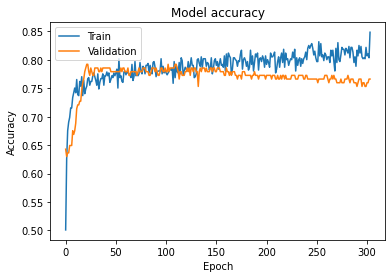

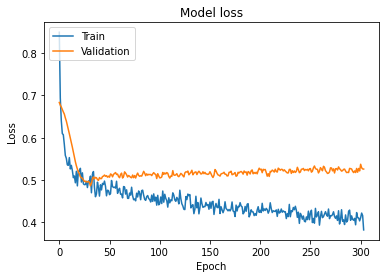

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [33]:
y_val

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

In [34]:
model.predict(x_val)

array([[0.6294758 ],
       [0.18735403],
       [0.13523903],
       [0.02737656],
       [0.06771219],
       [0.37575442],
       [0.00804591],
       [0.05340865],
       [0.03048438],
       [0.61531585],
       [0.8321364 ],
       [0.6346661 ],
       [0.3290984 ]], dtype=float32)